In [1]:
# необходимые библиотеки pm4py
import pm4py
from pm4py.objects.log.importer import xes
from pm4py.objects.conversion.log.versions import to_dataframe
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.algo.conformance.tokenreplay import factory as token_replay
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.pandas import case_statistics
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory

# блок вспомогательных библиотек
import os
import pandas as pd

# отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")

In [16]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [26]:
# подгружаем лог и конвертируем в таблицу
log = xes_importer.apply('\data\CCC19 - Log XES.xes')
log = to_dataframe.apply(log)

In [4]:
log.head()

,concept:name,lifecycle:transition,org:resource,time:timestamp,RESOURCE,ROUND,EVENTID,ACTIVITY,STAGE,VIDEOSTART,VIDEOEND,case:concept:name,case:variant,case:variant-index,case:creator
0,Hand washing,start,R_13_1C,2018-10-11 23:00:00+11:00,R_13_1C,Pre,1539301115461,Hand washing,Operator and Patient Preparation,55,67,1539302414925-video_1.3_CVC,Variant 1,1,Fluxicon Disco
1,Hand washing,complete,R_13_1C,2018-10-11 23:01:00+11:00,R_13_1C,Pre,1539301115461,Hand washing,Operator and Patient Preparation,55,67,1539302414925-video_1.3_CVC,Variant 1,1,Fluxicon Disco
2,Ultrasound configuration,start,R_13_1C,2018-10-11 23:01:00+11:00,R_13_1C,Pre,1539301145312,Ultrasound configuration,Ultrasound Preparation,84,137,1539302414925-video_1.3_CVC,Variant 1,1,Fluxicon Disco
3,Ultrasound configuration,complete,R_13_1C,2018-10-11 23:02:00+11:00,R_13_1C,Pre,1539301145312,Ultrasound configuration,Ultrasound Preparation,84,137,1539302414925-video_1.3_CVC,Variant 1,1,Fluxicon Disco
4,Anatomic identification,start,R_13_1C,2018-10-11 23:02:00+11:00,R_13_1C,Pre,1539301204591,Anatomic identification,Locate Structures,143,143,1539302414925-video_1.3_CVC,Variant 1,1,Fluxicon Disco


In [6]:
# делим на две части: до проведения практических занятий и после
pre = log[log['ROUND']=='Pre'].reset_index(drop=True)
post = log[log['ROUND']!='Pre'].reset_index(drop=True)

In [7]:
pre = pre[pre['lifecycle:transition']=='complete'].reset_index(drop=True)
pre = pre.sort_values(['RESOURCE', 'time:timestamp'], ascending = True)

post = post[post['lifecycle:transition']=='complete'].reset_index(drop=True)
post = post.sort_values(['RESOURCE', 'time:timestamp'], ascending = True)

> Теперь переводим полученные таблицы в логи

In [8]:
pre_log = conversion_factory.apply(pre)
post_log = conversion_factory.apply(post)

> В качестве ознакомления можно посмотреть варианты прохождения учениками всего процесса и посмотреть их частоту встречаемости

In [9]:
variants = variants_filter.get_variants(pre_log)

In [10]:
variants = case_statistics.get_variants_df(pre,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "RESOURCE",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name"})

In [11]:
variants_count = case_statistics.get_variant_statistics(pre_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

In [12]:
pd.DataFrame(variants_count)

,variant,count
0,"Ultrasound configuration,Anatomic identificati...",1
1,"Prepare implements,Ultrasound configuration,Po...",1
2,"Prepare implements,Position patient,Hand washi...",1
3,"Prepare implements,Get in sterile clothes,Ultr...",1
4,"Position patient,Ultrasound configuration,Gel ...",1
5,"Hand washing,Ultrasound configuration,Anatomic...",1
6,"Get in sterile clothes,Hand washing,Position p...",1
7,"Get in sterile clothes,Hand washing,Get in ste...",1
8,"Get in sterile clothes,Hand washing,Get in ste...",1
9,"Get in sterile clothes,Hand washing,Get in ste...",1


# Petri Net

> Собственно, сама сеть Петри эталонного процесса. В данном случае из-за малого количества ветвлений, она очень даже читабельно выглядит

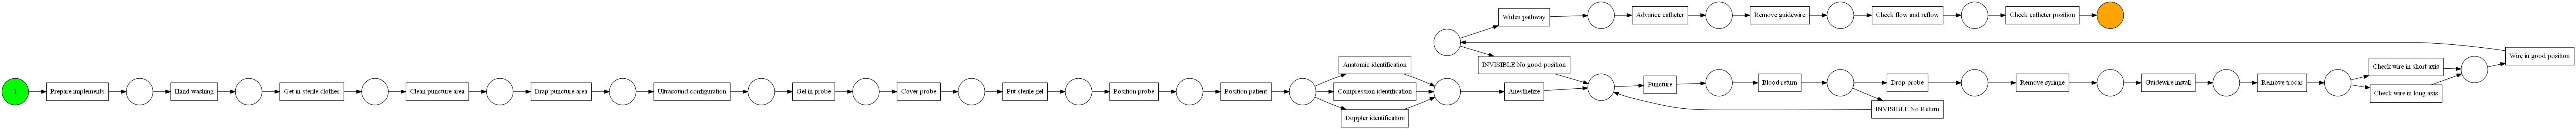

In [65]:
from pm4py.objects.petri.importer import importer as pnml_importer
net, initial_marking, final_marking = pnml_importer.apply('\data\CCC19 - Model PN.pnml')

from pm4py.visualization.petrinet import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

# Footprint based conformance

> Для проведения данного метода проверки необходимо обработать лог Inductive Miner. Для того, чтобы посмотреть суть, воспользуемся встроенной визуализацией

In [ ]:
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.process_tree import factory as pt_vis_factory

In [18]:
# применение майнера
tree = inductive_miner.apply_tree(pre_log)

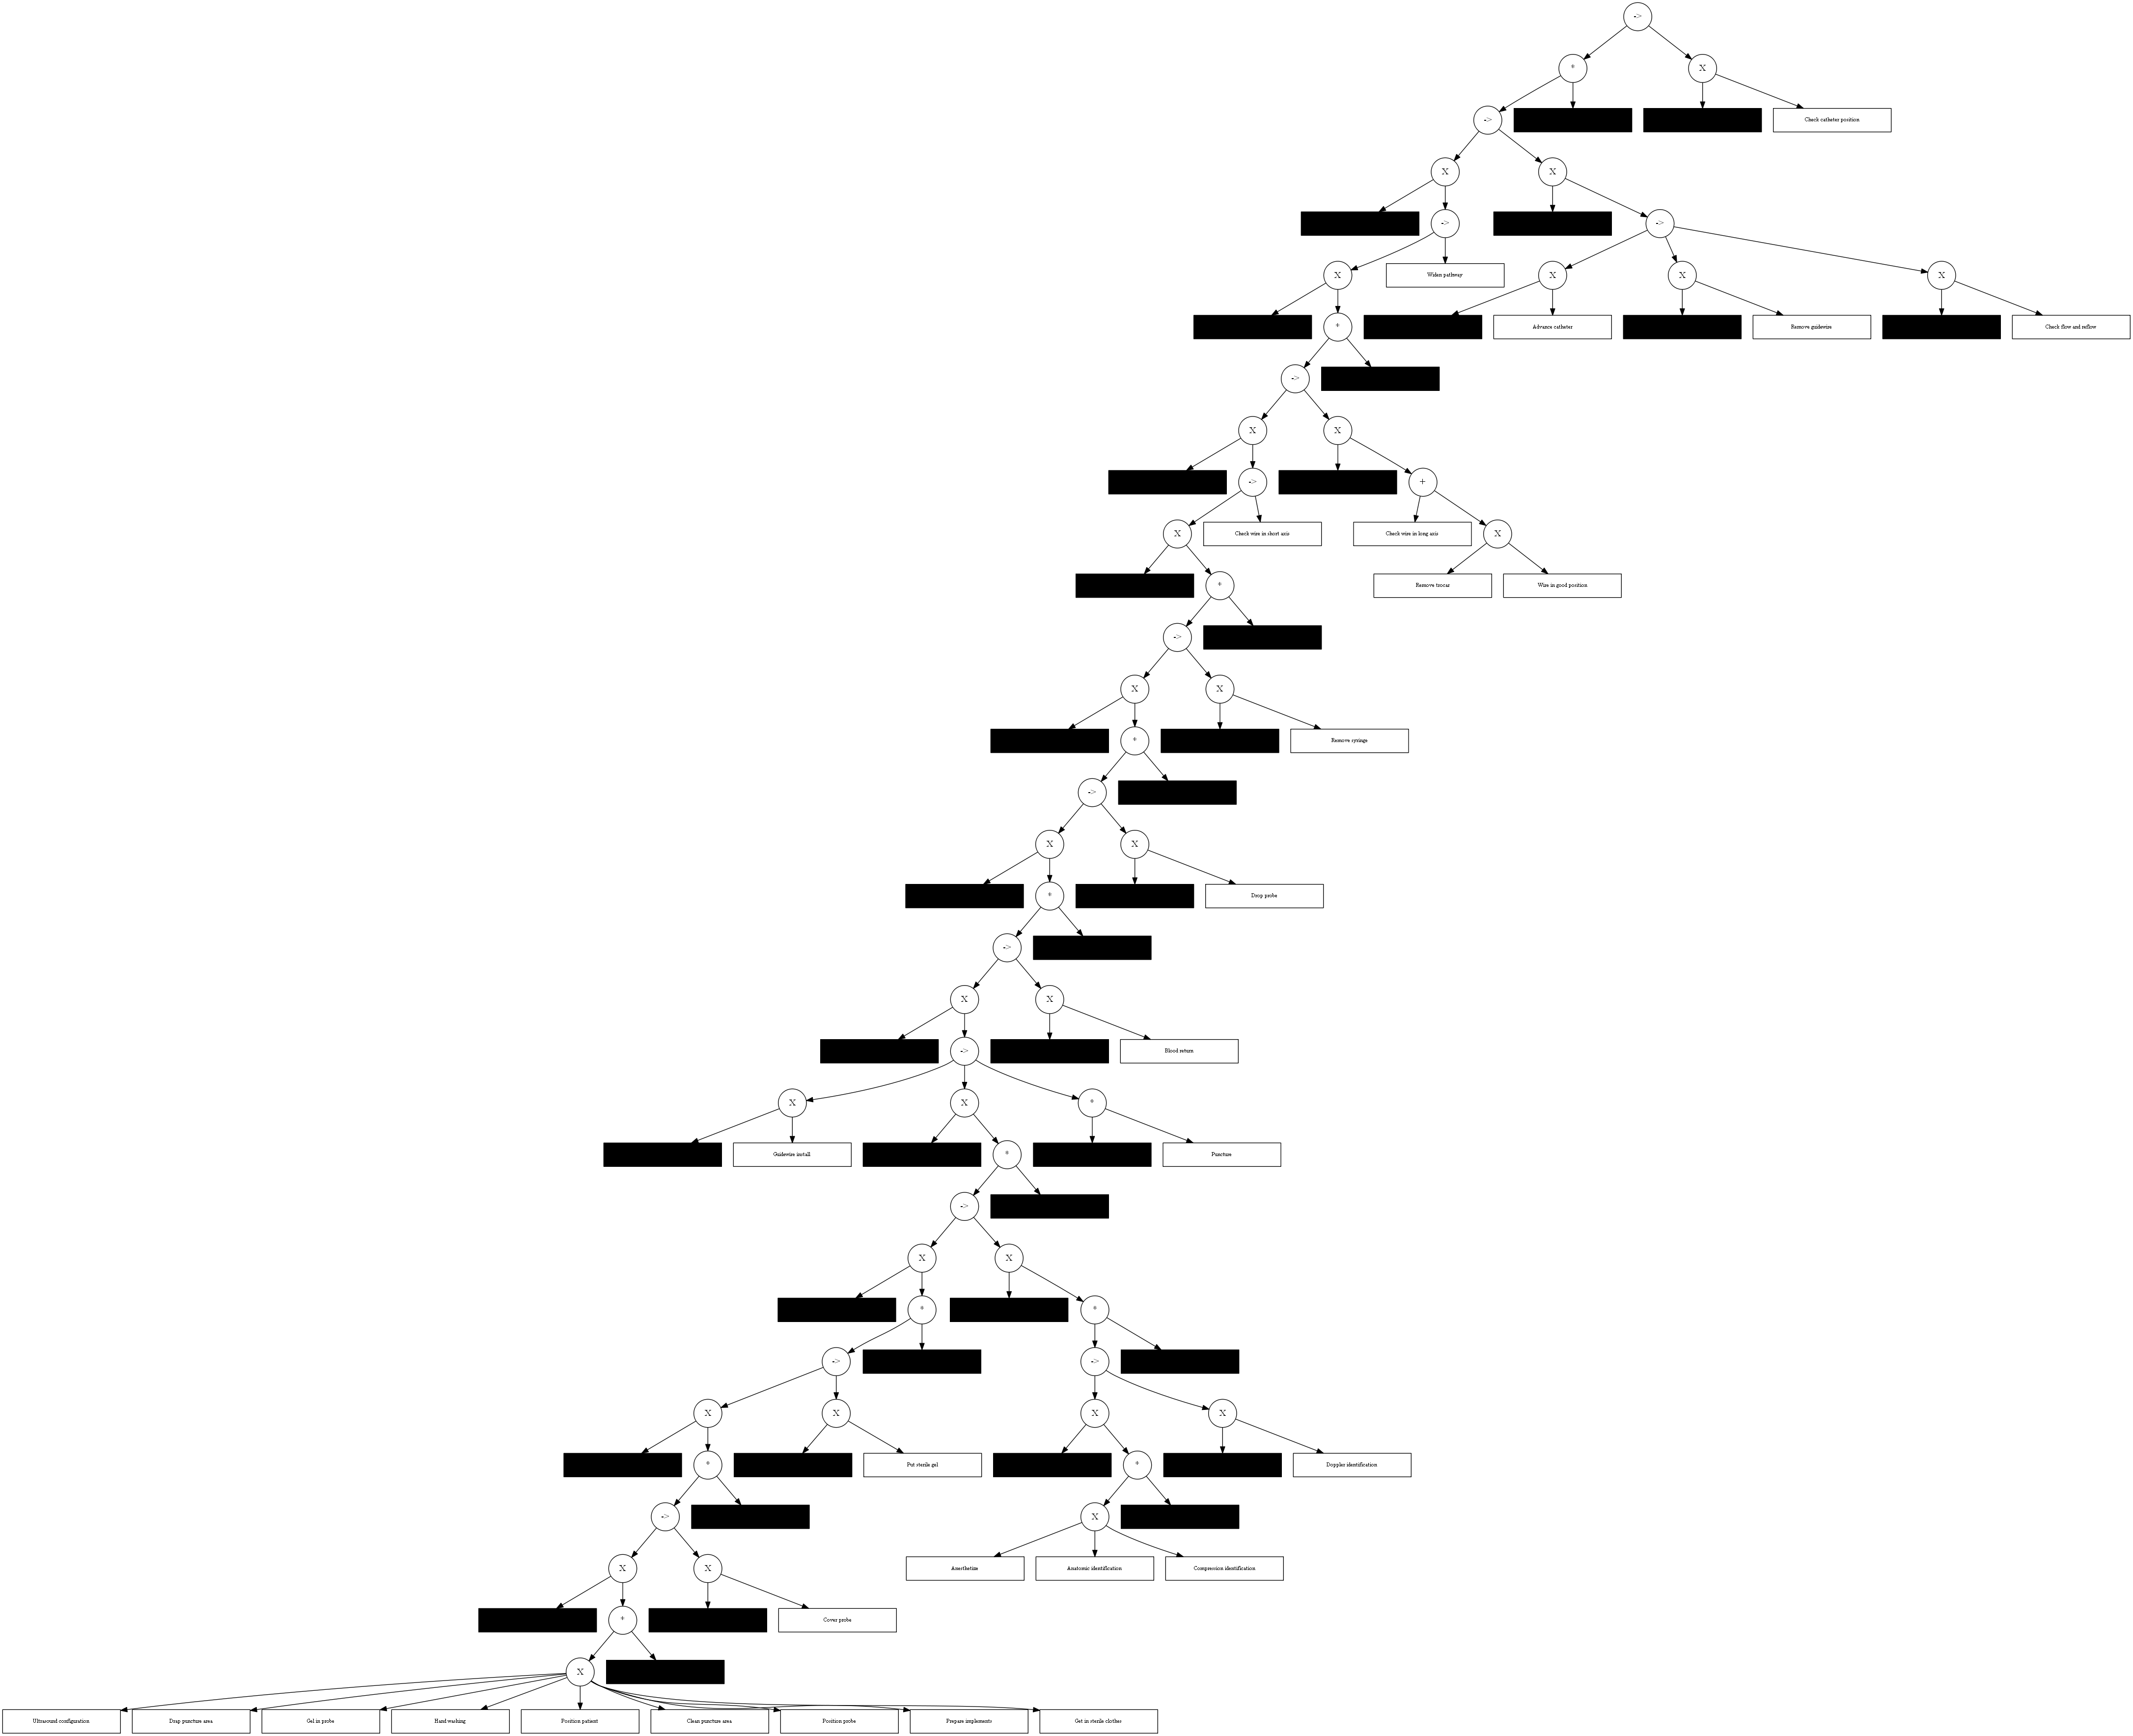

In [19]:
# визуализация полученного дерева
gviz = pt_vis_factory.apply(tree)
pt_vis_factory.view(gviz)

In [20]:
# применяем отдельно к логу footprints
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
fp_log = footprints_discovery.apply(pre_log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

In [21]:
# применяем отдельно к эталонному процессу footprints
fp_net = footprints_discovery.apply(net, initial_marking, final_marking)

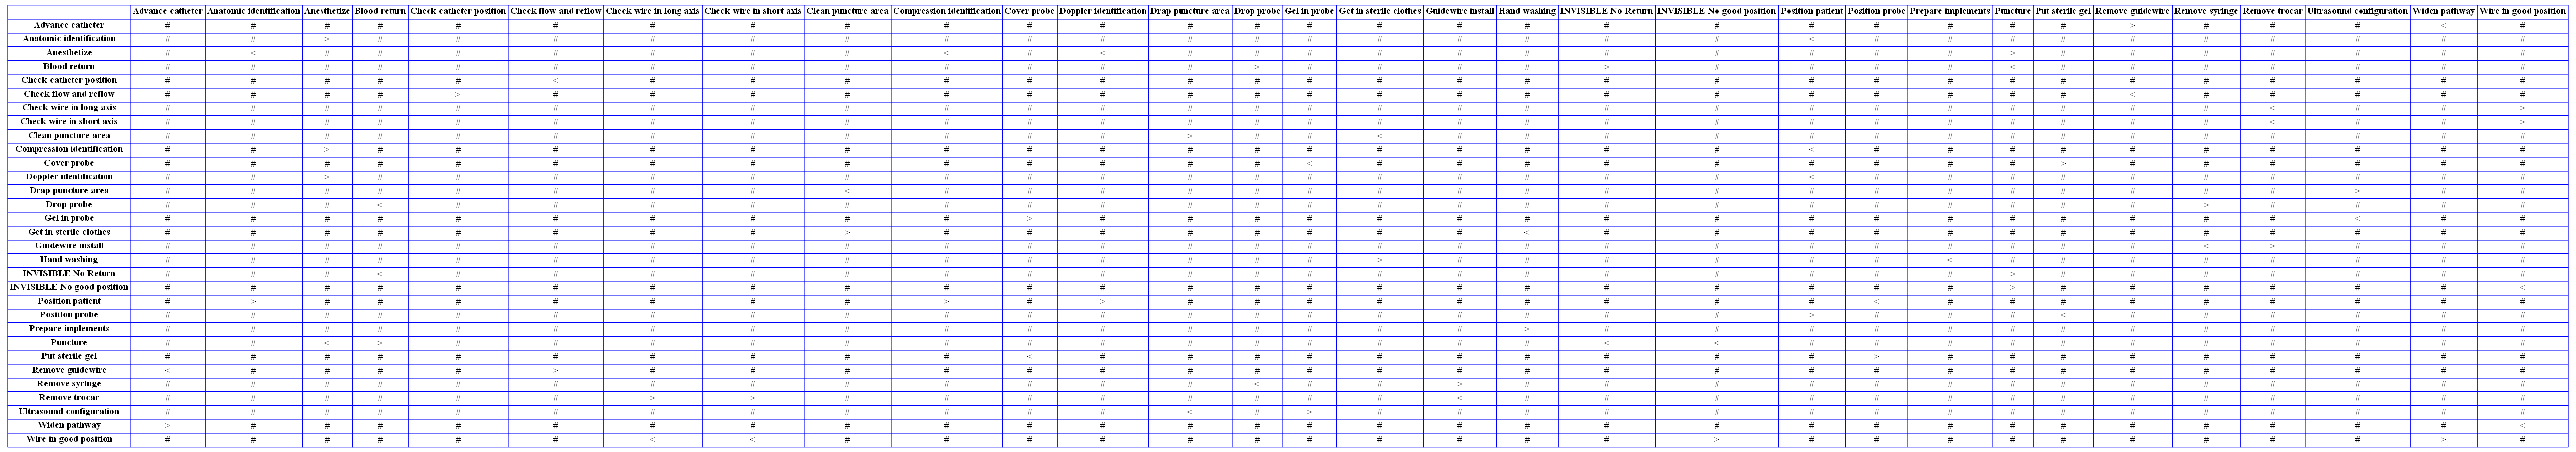

In [22]:
# визуализируем эталонную табличку
from pm4py.visualization.footprints import visualizer as fp_visualizer
gviz = fp_visualizer.apply(fp_net)
fp_visualizer.view(gviz)

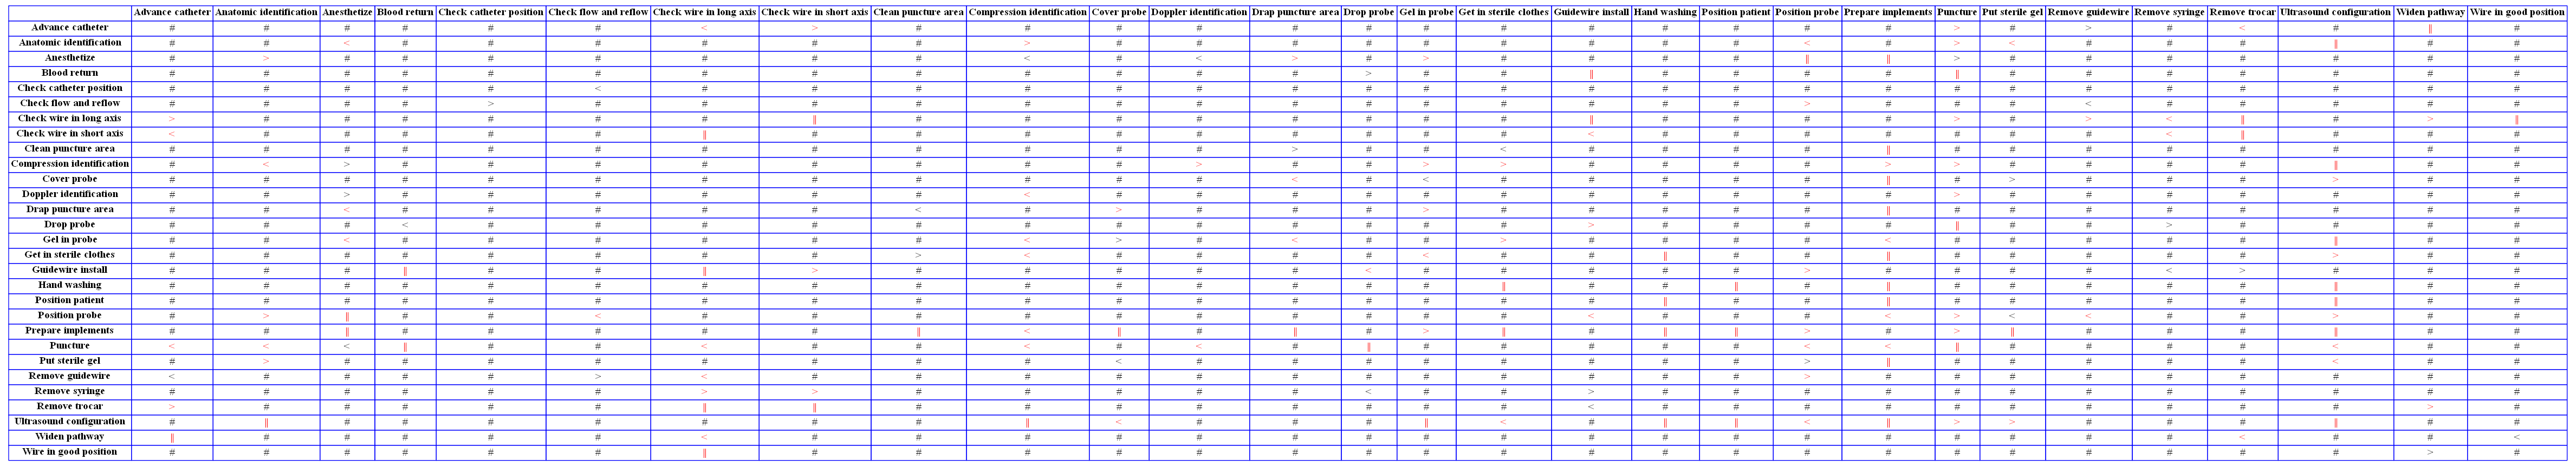

In [23]:
# а теперь визуализируем конфликты, они подсвечены красным
from pm4py.visualization.footprints import visualizer as fp_visualizer
gviz = fp_visualizer.apply(fp_log, fp_net)
fp_visualizer.view(gviz)

In [39]:
# footprints можно также считать по каждому trace, так мы сможем посчитать метрику общего соответствия
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
fp_trace_by_trace = footprints_discovery.apply(pre_log, variant=footprints_discovery.Variants.TRACE_BY_TRACE)

In [40]:
from pm4py.algo.conformance.footprints import algorithm as footprints_conformance

conf_fp = footprints_conformance.apply(fp_trace_by_trace, fp_net)

In [41]:
dev_counter = 0
for trace in conf_fp:
    for deviation in trace:
        dev_counter+=len(deviation)

In [42]:
number_of_cells = len(set(pre['concept:name'])) ** 2

In [43]:
fintess_value = 1 - dev_counter/number_of_cells

In [44]:
print(fintess_value)

0.5719381688466112


# Token-based replay

> Для проведения используем путь к сети Петри и ее метки, далее посчитаем метрику соответствия согласно методу

In [45]:
pnml_path = r'data\CCC19 - Model PN.pnml'

In [46]:
def replay_fitness_calculation(real_log, etalon_petri_path):
    net, initial_marking, final_marking = pnml_importer.apply(etalon_petri_path)
    replay_result = token_replay.apply(real_log, net, initial_marking, final_marking)
    log_fitness = replay_fitness_factory.evaluate(replay_result, variant="token_replay")
    return log_fitness

In [50]:
# Сводная по результатам анализа соответсвий
replay_result = replay_fitness_calculation(pre_log, pnml_path)
print(replay_result)

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6324897958596584, 'log_fitness': 0.6210526315789473}


In [51]:
from pm4py.algo.conformance.tokenreplay import factory as token_replay
replay_result, place_fitness, trans_fitness, notexisting_activities_in_model = token_replay.apply(pre_log, net, initial_marking, final_marking, parameters={"enable_pltr_fitness": True})

> А теперь представим подробную сводную таблицу с результатми по каждой trace

In [52]:
rr = pd.DataFrame(replay_result)[['trace_is_fit','trace_fitness','activated_transitions','enabled_transitions_in_marking',
                            'transitions_with_problems','missing_tokens','consumed_tokens','remaining_tokens','produced_tokens']]

In [53]:
rr.columns =['trace_is_fit','trace_fitness','activated_transitions','enabled_transitions_in_marking',
                            'transitions_with_problems','M','C','R','P']

In [54]:
rr

,trace_is_fit,trace_fitness,activated_transitions,enabled_transitions_in_marking,transitions_with_problems,M,C,R,P
0,False,0.647059,"[Hand washing, Ultrasound configuration, Anato...","{Position probe, Clean puncture area, Wire in ...","[Hand washing, Ultrasound configuration, Anato...",12,34,12,34
1,False,0.718750,"[Get in sterile clothes, Hand washing, Positio...","{Check wire in short axis, Gel in probe, Hand ...","[Get in sterile clothes, Hand washing, Positio...",9,32,9,32
2,False,0.550000,"[Prepare implements, Get in sterile clothes, U...","{Check catheter position, Ultrasound configura...","[Get in sterile clothes, Ultrasound configurat...",27,60,27,60
3,False,0.638298,"[Prepare implements, Ultrasound configuration,...","{Check catheter position, Remove guidewire, Po...","[Ultrasound configuration, Position patient, P...",17,47,17,47
4,False,0.567568,"[Get in sterile clothes, Hand washing, Get in ...","{Drop probe, Gel in probe, Hand washing, Anest...","[Get in sterile clothes, Hand washing, Gel in ...",16,37,16,37
5,False,0.583333,"[Prepare implements, Position patient, Hand wa...","{Drop probe, Check wire in short axis, Gel in ...","[Position patient, Prepare implements, Prepare...",15,36,15,36
6,False,0.461538,"[Ultrasound configuration, Anatomic identifica...","{Check wire in short axis, Ultrasound configur...","[Ultrasound configuration, Anatomic identifica...",21,39,21,39
7,False,0.741935,"[Position patient, Ultrasound configuration, G...","{Position patient, Clean puncture area, Wire i...","[Position patient, Ultrasound configuration, G...",8,31,8,31
8,False,0.740741,"[Get in sterile clothes, Hand washing, Get in ...","{Check wire in long axis, Check wire in short ...","[Get in sterile clothes, Hand washing, Gel in ...",7,27,7,27
9,False,0.675676,"[Get in sterile clothes, Hand washing, Get in ...","{Check wire in short axis, Gel in probe, Hand ...","[Get in sterile clothes, Hand washing, Gel in ...",12,37,12,37


# Alignment 

> Опять применим альфа майнер на лог, но уже чтобы привести его к форме сети Петри, а затем сделать наложение

In [ ]:
from pm4py.algo.conformance.alignments import factory as align_factory
%time alignments = align_factory.apply_log(pre_log, net, initial_marking, final_marking)

In [ ]:
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory
log_fitness = replay_fitness_factory.evaluate(alignments, variant="alignments")

In [ ]:
print(log_fitness)

In [ ]:
print(alignments)

> Далее можно ознакомиться с **тестовой** визуализацией, которая все еще в разработке и пока офицально не представлена. 

>Красные ячейки - ячейки не соответствий. 

>В каждой ячейке есть **два числа**:
- число **слева**: кол-во прохождений в **модели**
- число **справа**: кол-во прохождений в **логе**

In [ ]:
alignments = align_factory.apply(pre_log, net, im, fm, parameters={"ret_tuple_as_trans_desc": True})

In [ ]:
from pm4py.visualization.petrinet.util import alignments_decoration
decorations = alignments_decoration.get_alignments_decoration(net, im, fm, log=pre_log)

In [ ]:
from pm4py.visualization.petrinet import factory as pn_vis_factory

gviz = pn_vis_factory.apply(net, im, fm, log=pre_log, variant="alignments")
pn_vis_factory.view(gviz)

In [ ]:
from pm4py.visualization.petrinet import factory as pn_vis_factory

gviz = pn_vis_factory.apply(net, im, fm, aggregated_statistics=decorations, variant="alignments")
pn_vis_factory.view(gviz)

# BPMN

In [55]:
# импорт модуля и загрузка диаграммы процесса 
from pm4pybpmn.objects.bpmn.importer import bpmn20 as bpmn_importer
bpmn_graph = bpmn_importer.import_bpmn(r'\data\CCC19 - Model BPMN.bpmn')

In [56]:
# конвертация bpmn в petri net
from pm4pybpmn.objects.conversion.bpmn_to_petri import factory as bpmn_to_petri
net, im, fm, elements_correspondence, inv_elements_correspondence, el_corr_keys_map = bpmn_to_petri.apply(bpmn_graph)

> Далее можно ознакомиться с **тестовой** визуализацией, которая **тоже** в разработке и пока офицально не представлена. 

In [ ]:
from pm4pybpmn.visualization.bpmn import factory as bpmn_vis_factory
gviz = bpmn_vis_factory.apply_petri(net, im, fm, log=pre_log, variant="alignments")